# 1. Import Dependencies

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda:0 is available


# 2. Load Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # mean, std
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


# 3. Construct Model

In [34]:
# 32 x 32 x 1, 1 is called channel(i.e., RGB, HSV, etc)
# filter = kernel
# stride: 필터가 움직이는 보폭
# padding: 이미지 밖을 특정 값으로 채우는 것(e.g., zero padding)
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # 1. Feature Extraction
        self.features = nn.Sequential(
            # input size = 64 x 30 x 30
            # W_out = ((W_in - k + 2p) / s) + 1
            # H_out = ((H_in - k + 2p) / s) + 1
            # Conv1
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3),
            nn.ReLU(),
            # Max Pool1
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            # Conv2
            nn.Conv2d(in_channels = 64, out_channels = 192, kernel_size = 3, padding = 1),
            nn.ReLU(),
            # Max Pool2
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            # Conv3
            nn.Conv2d(in_channels = 192, out_channels = 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            # Conv4
            nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            # Conv5
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 1),
            nn.ReLU(),
            # Max Pool3
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        # 2. Classifier
        self.classifier = nn.Sequential(
            # fc1
            nn.Dropout(),
            nn.Linear(in_features = 256 * 3 * 3, out_features = 1024),
            nn.ReLU(),
            # fc2
            nn.Dropout(),
            nn.Linear(in_features = 1024, out_features = 512),
            nn.ReLU(),
            # fc3
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 3 * 3)
        x = self.classifier(x)
        return x

In [35]:
criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(), lr = 1e-3)

In [36]:
summary(alexnet, (3, 30, 30))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,792
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 192, 14, 14]         110,784
              ReLU-5          [-1, 192, 14, 14]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          65,792
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
          Dropout-14                 [-

# 4. Model Training

In [37]:
loss_ = []
n = len(trainloader)
for epoch in range(1, 51):
    running_loss = 0.0
    # Wrap the trainloader with tqdm to show progress
    for data in tqdm(trainloader, desc=f"Epoch {epoch}/50"):
        inputs, labels = data[0].to(device), data[1].to(device)  # batch data
        optimizer.zero_grad()
        outputs = alexnet(inputs)  # calc prediction
        loss = criterion(outputs, labels)  # calc loss
        loss.backward()  # backpropagation
        optimizer.step()  # update weight
        running_loss += loss.item()

    loss_.append(running_loss / n)
    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {running_loss / len(trainloader)}')

Epoch 10/50: 100%|█████████████████████████| 1563/1563 [00:14<00:00, 105.55it/s]


epoch: 10, loss: 0.5971091660889615


Epoch 20/50: 100%|█████████████████████████| 1563/1563 [00:14<00:00, 108.58it/s]


epoch: 20, loss: 0.392103565457591


Epoch 30/50: 100%|█████████████████████████| 1563/1563 [00:14<00:00, 108.09it/s]


epoch: 30, loss: 0.3016152037170573


Epoch 40/50: 100%|█████████████████████████| 1563/1563 [00:15<00:00, 103.19it/s]


epoch: 40, loss: 0.2667211317263606


Epoch 50/50: 100%|██████████████████████████| 1563/1563 [00:15<00:00, 99.55it/s]

epoch: 50, loss: 0.2672241702173811


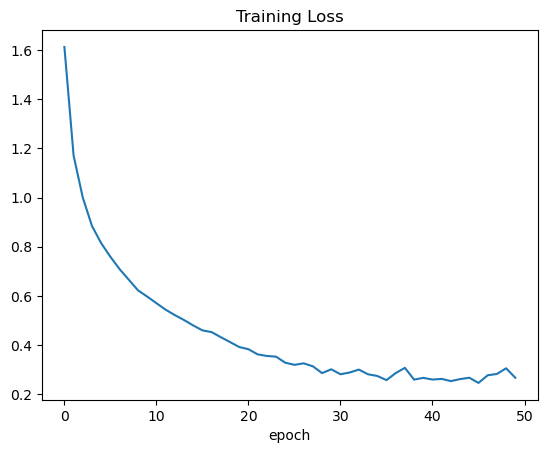

In [38]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

# 5. Save Model and Load Model

In [39]:
PATH = './models/cifar_alexnet.pth'
torch.save(alexnet.state_dict(), PATH)

In [40]:
alexnet = AlexNet().to(device)
alexnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# 6. Model Evaluation

In [42]:
correct = 0
total = 0
with torch.no_grad():
    alexnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # correct: 1, incorrect: 0 ~ sum

print(f'Test accuracy: {(100 * correct / total):.2f}%')

Test accuracy: 75.65%
